In [53]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import envs
import os
import logging

from utils import config
from agent import Agent, RandomPolicy
from mpc import MPC
from cem import CEMOptimizer
from model import PENN
%load_ext autoreload
%autoreload 2

# Logging
now = config.Now()
log = logging.getLogger('root')
log.setLevel('INFO')
log.addHandler(config.MyHandler())

INFO = 10

# Training params
TASK_HORIZON = 40
PLAN_HORIZON = 5

# CEM params
POPSIZE = 200
NUM_ELITES = 20
MAX_ITERS = 5

# Model params
LR = 1e-3

# Dims
STATE_DIM = 8

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Debug

In [61]:
env_name="Pushing2D-v1"
num_nets=3
mpc_params = {"use_mpc": True, "num_particles": 6}
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 
env = gym.make(env_name)
task_horizon = TASK_HORIZON

agent = Agent(env)
mpc_params["use_gt_dynamics"] = False
# dynamics model f(s, a, phi)
model = PENN(num_nets, STATE_DIM, len(env.action_space.sample()), LR, device=device)
cem_policy = MPC(env, PLAN_HORIZON, model, POPSIZE, NUM_ELITES, MAX_ITERS, 
                      **mpc_params, use_random_optimizer=False)
random_policy = MPC(env, PLAN_HORIZON, model, POPSIZE, NUM_ELITES, MAX_ITERS, 
                         **mpc_params, use_random_optimizer=True)

Env

In [4]:
# sampling
env.get_nxt_state([1.        , 1.        , 2.        , 2.        , 0.        ,
       0.        , 0.        , 0.        , 3.71568806, 3.24443683], [1,0])

array([1.25, 1.  , 2.  , 2.  , 1.  , 0.  , 0.  , 0.  ])

In [7]:
# step
env.reset()
observation, reward, terminated, info = env.step([1,0])
print(observation, reward, terminated, info)

[1.25       1.         2.         2.         1.         0.
 0.         0.         3.2470543  3.76591662] -1 False {'done': None}


Model

In [80]:
# model forward
state_dim_input = torch.randn((5, 10,)).to(device)
output = model(state_dim_input)
print([(o[0].size(), o[1].size()) for o in output])

[(torch.Size([5, 8]), torch.Size([5, 8])), (torch.Size([5, 8]), torch.Size([5, 8])), (torch.Size([5, 8]), torch.Size([5, 8]))]


In [85]:
output_2 = torch.stack(list(map(lambda x: torch.stack(x, axis=1), output)), axis=1)
state_dim_input_2 = torch.stack([state_dim_input[...,:STATE_DIM]]*num_nets, axis=1)
print(output_2.size(), state_dim_input_2.size())
# for loss calcuation
print(state_dim_input_2.size(), output_2[..., 0, :].size(), output_2[..., 1, :].size())
model.get_loss(state_dim_input_2, output_2[..., 0, :], output_2[..., 1, :]).item()

torch.Size([5, 3, 2, 8]) torch.Size([5, 3, 8])
torch.Size([5, 3, 8]) torch.Size([5, 3, 8]) torch.Size([5, 3, 8])


6.449945449829102

MPC

In [165]:
mean, logvar = output[0]
var = torch.diag_embed(torch.exp(logvar))
print(mean.size(), logvar.size(), var.size())
delta = torch.distributions.multivariate_normal.MultivariateNormal(mean, var).rsample()
print(delta.shape)

torch.Size([5, 8]) torch.Size([5, 8]) torch.Size([5, 8, 8])
torch.Size([5, 8])


In [169]:
ac_seqs = np.tile(np.array([1,0])[None],[POPSIZE,PLAN_HORIZON])
print(ac_seqs.shape)
next_state= random_policy.predict_next_state_model(state_dim_input[:, :-2], state_dim_input[:,-2:])
print(next_state.size())

(200, 10)
torch.Size([5, 8]) torch.Size([5, 8])
torch.Size([5, 8])


### Run here (from run.py)

In [206]:
class ExperimentGTDynamics(object):
    def __init__(self, env_name="Pushing2D-v1", mpc_params=None):
        self.env = gym.make(env_name)
        self.task_horizon = TASK_HORIZON
        self.agent = Agent(self.env)
        self.warmup = False

        # Use Ground Truth Dynamics
        mpc_params["use_gt_dynamics"] = True

        # Model Predictive Contoal (MPC)
        self.cem_policy = MPC(self.env, PLAN_HORIZON, None, POPSIZE, NUM_ELITES, MAX_ITERS, **mpc_params,
                              use_random_optimizer=False)
        self.random_policy = MPC(self.env, PLAN_HORIZON, None, POPSIZE, NUM_ELITES, MAX_ITERS, **mpc_params,
                                 use_random_optimizer=True)

    def test(self, num_episodes, optimizer="cem"):
        samples = []
        for j in range(num_episodes):
            if j == 0 or (j + 1) % INFO == 0: log.info("Test episode {}".format(j))
            samples.append(
                self.agent.sample(
                    self.task_horizon, self.cem_policy if optimizer == "cem" else self.random_policy
                )
            )
        avg_return = np.mean([sample["reward_sum"] for sample in samples])
        avg_success = np.mean([sample["rewards"][-1] == 0 for sample in samples])
        return avg_return, avg_success


class ExperimentModelDynamics:
    def __init__(self, env_name="Pushing2D-v1", num_nets=1, mpc_params=None, device=None):
        self.env = gym.make(env_name)
        self.task_horizon = TASK_HORIZON

        self.agent = Agent(self.env)
        mpc_params["use_gt_dynamics"] = False
        # dynamics model f(s, a, phi)
        self.model = PENN(num_nets, STATE_DIM, len(self.env.action_space.sample()), LR, device=device)
        self.cem_policy = MPC(self.env, PLAN_HORIZON, self.model, POPSIZE, NUM_ELITES, MAX_ITERS, **mpc_params,
                              use_random_optimizer=False)
        self.random_policy = MPC(self.env, PLAN_HORIZON, self.model, POPSIZE, NUM_ELITES, MAX_ITERS, **mpc_params,
                                 use_random_optimizer=True)

    def test(self, num_episodes, optimizer="cem"):
        samples = []
        for j in range(num_episodes):
            if j == 0 or (j + 1) % INFO == 0: log.info("Test episode {}".format(j))
            samples.append(
                self.agent.sample(
                    self.task_horizon, self.cem_policy if optimizer == "cem" else self.random_policy
                )
            )
        avg_return = np.mean([sample["reward_sum"] for sample in samples])
        avg_success = np.mean([sample["rewards"][-1] == 0 for sample in samples])
        return avg_return, avg_success

    def model_warmup(self, num_episodes, num_train_itrs):
        """ 
        Train a single probabilistic model using a random policy 
            :param num_episodes: randomly sampled episodes for training the a single probabilistic network
            :param num_train_itrs: number of iterations to pre-train the ensemble of networks for
        """
        traj_obs, traj_acs, traj_rews = [], [], []

        samples = []
        for i in range(num_episodes):
            if i == 0 or (i + 1) % 100 == 0: log.info("Warm up episode %d" % (i))
            samples.append(self.agent.sample(self.task_horizon, self.random_policy))

            traj_obs.append(samples[-1]["obs"])
            traj_acs.append(samples[-1]["ac"])
            traj_rews.append(samples[-1]["rewards"])

        losses = self.cem_policy.train(
            [sample["obs"] for sample in samples],
            [sample["ac"] for sample in samples],
            [sample["rewards"] for sample in samples],
            num_train_itrs=num_train_itrs
        )
        self.random_policy.model = self.cem_policy.model
        self.random_policy.has_been_trained = True

        self.traj_obs, self.traj_acs, self.traj_rews = traj_obs, traj_acs, traj_rews
        self.warmup = True
        return losses

    def train(self, num_train_itrs, num_episodes_per_itr, evaluation_interval):
        """ 
        MBRL with PETS (Algorithm 1)
        """
        if self.warmup:
            traj_obs, traj_acs, traj_rews = self.traj_obs, self.traj_acs, self.traj_rews
        else:
            traj_obs, traj_acs, traj_rews = [], [], []

        cme_test, rnd_test, loss = [], [], []
        for i in range(num_train_itrs):
            log.info("####################################################################")
            log.info("Starting training iteration %d." % (i + 1))

            samples = []
            for j in range(num_episodes_per_itr):
                samples.append(
                    self.agent.sample(
                        self.task_horizon, self.cem_policy
                    )
                )
            log.info("Rewards obtained: {}, Rollout Length: {}".format(
                [sample["reward_sum"] for sample in samples], len(samples[-1]["obs"])))
            traj_obs.extend([sample["obs"] for sample in samples])
            traj_acs.extend([sample["ac"] for sample in samples])
            traj_rews.extend([sample["rewards"] for sample in samples])

            losses = self.cem_policy.train(
                [sample["obs"] for sample in samples],
                [sample["ac"] for sample in samples],
                [sample["rewards"] for sample in samples],
                num_train_itrs=5
            )
            loss.append(losses[-1])
            self.random_policy.model = self.cem_policy.model
            self.random_policy.has_been_trained = True

            # Q1.2.7: Test with both CEM + MPC & Random Policy + MPC
            if i == 0 or (i + 1) % evaluation_interval == 0:
                avg_return, avg_success = self.test(20, optimizer="cem")
                log.info("Test success CEM + MPC: {}".format(avg_success))
                cme_test.append([avg_return, avg_success])
                avg_return, avg_success = self.test(20, optimizer="random")
                log.info("Test success Random + MPC: {}".format(avg_success))
                rnd_test.append([avg_return, avg_success])

        return cme_test, rnd_test, loss


def test_cem_gt_dynamics(num_episode=50):
    log.info("### Q1.1.1: CEM (without MPC)")
    mpc_params = {'use_mpc': False, 'num_particles': 1}
    exp = ExperimentGTDynamics(env_name="Pushing2D-v1", mpc_params=mpc_params)
    avg_reward, avg_success = exp.test(num_episode, optimizer="cem")
    log.info("CEM PushingEnv: avg_reward: {}, avg_success: {}".format(avg_reward, avg_success))

    log.info("### Q1.1.2: Random Policy (without MPC)")
    mpc_params = {"use_mpc": False, "num_particles": 1}
    exp = ExperimentGTDynamics(env_name="Pushing2D-v1", mpc_params=mpc_params)
    avg_reward, avg_success = exp.test(num_episode, optimizer="random")
    log.info("Random PushingEnv: avg_reward: {}, avg_success: {}".format(avg_reward, avg_success))

    log.info("### Q1.1.2: Random Policy + MPC")
    mpc_params = {"use_mpc": True, "num_particles": 1}
    exp = ExperimentGTDynamics(env_name="Pushing2D-v1", mpc_params=mpc_params)
    avg_reward, avg_success = exp.test(num_episode, optimizer="random")
    log.info("Random + MPC PushingEnv: avg_reward: {}, avg_success: {}".format(avg_reward, avg_success))

    log.info("### Q1.1.3:")
    for env_name in ["Pushing2D-v1", "Pushing2DNoisyControl-v1"]:
        # CEM (without MPC)
        mpc_params = {"use_mpc": False, "num_particles": 1}
        exp = ExperimentGTDynamics(env_name=env_name, mpc_params=mpc_params)
        avg_reward, avg_success = exp.test(num_episode, optimizer="cem")
        log.info("CEM {}: avg_reward: {}, avg_success: {}".format(env_name[:-3], avg_reward, avg_success))

        # CEM + MPC
        mpc_params = {"use_mpc": True, "num_particles": 1}
        exp = ExperimentGTDynamics(env_name=env_name, mpc_params=mpc_params)
        avg_reward, avg_success = exp.test(num_episode, optimizer="cem")
        log.info("CEM + MPC {}: avg_reward: {}, avg_success: {}".format(env_name[:-3], avg_reward, avg_success))


def plot_loss(losses, title, fpath):
    plt.figure(dpi=100)
    plt.plot(losses)
    plt.xlabel('Iterations')
    plt.ylabel('Negative Log Likelihood')
    plt.title(title)
    plt.tight_layout(pad=0)
    plt.savefig(fpath)


def train_single_dynamics(num_test_episode=50, device=None):
    log.info("### Q1.2.1: Train a single dynamics model f(s, a, phi) using a random policy")
    num_nets = 1
    num_episodes = 1000
    num_train_itrs = 100
    mpc_params = {"use_mpc": True, "num_particles": 6}
    exp = ExperimentModelDynamics(env_name="Pushing2D-v1", num_nets=num_nets, mpc_params=mpc_params, device=device)

    log.info("### Q1.2.1: Train from 1000 randomly sampled episodes with 100 iterations")
    losses = exp.model_warmup(num_episodes=num_episodes, num_train_itrs=num_train_itrs)
    plot_loss(losses, '2.2.1: Single Network Training', 'out/2.2.1-loss.png')

    log.info("### Q1.2.2: Test with Random Policy for %d episodes" % num_test_episode)
    avg_reward, avg_success = exp.test(num_test_episode, optimizer="random")
    log.info("Single + Random: avg_reward: {}, avg_success: {}".format(avg_reward, avg_success))

    log.info("### Q1.2.3: Test with CEM for %d episodes" % num_test_episode)
    avg_reward, avg_success = exp.test(num_test_episode, optimizer="cem")
    log.info("Single + CEM: avg_reward: {}, avg_success: {}".format(avg_reward, avg_success))


def train_pets(device=None):
    # MBRL with PETS
    log.info("### Q1.3.1: Train an ensemble of probabilistic dynamics model (PETS)")
    num_nets = 2
    num_train_itrs = 500
    evaluation_interval = 50
    num_episodes_per_itr = 1

    mpc_params = {"use_mpc": True, "num_particles": 6}
    exp = ExperimentModelDynamics(env_name="Pushing2D-v1", num_nets=num_nets, mpc_params=mpc_params, device=device)

    log.info("### Q1.3.1: Train from 100 randomly sampled episodes + 500 MPC iterations")
    exp.model_warmup(num_episodes=100, num_train_itrs=10)
    cme_test, rnd_test, loss = exp.train(
        num_train_itrs=num_train_itrs,
        num_episodes_per_itr=num_episodes_per_itr,
        evaluation_interval=evaluation_interval)
    plot_loss(loss, '1.3.1: PETS model loss', 'out/1.3.1-loss.png')

    log.info("### Q1.3.2: Plot CEM + MPC v.s. Random Policy + MPC over training")
    for i, name in enumerate(["Returns", "Success Rate"]):
        plt.figure(dpi=100)
        plt.plot(np.arange(len(cme_test)) * 50, np.array(cme_test)[:, i], label="CEM + MPC")
        plt.plot(np.arange(len(cme_test)) * 50, np.array(rnd_test)[:, i], label="Random + MPC")
        plt.xlabel("Training Iterations")
        plt.ylabel(name)
        plt.legend()
        plt.savefig("out/%d-cem-vs-random-%s.png" % (num_nets, name), bbox_inches="tight")

2022-11-22 02:21:53 3278655113.py INFO    : ### Q1.3.1: Train an ensemble of probabilistic dynamics model (PETS)
2022-11-22 02:21:53 3278655113.py INFO    : ### Q1.3.1: Train an ensemble of probabilistic dynamics model (PETS)
2022-11-22 02:21:53 3278655113.py INFO    : ### Q1.3.1: Train an ensemble of probabilistic dynamics model (PETS)
2022-11-22 02:21:53 3278655113.py INFO    : ### Q1.3.1: Train an ensemble of probabilistic dynamics model (PETS)
2022-11-22 02:21:53 3278655113.py INFO    : ### Q1.3.1: Train from 100 randomly sampled episodes + 500 MPC iterations
2022-11-22 02:21:53 3278655113.py INFO    : ### Q1.3.1: Train from 100 randomly sampled episodes + 500 MPC iterations
2022-11-22 02:21:53 3278655113.py INFO    : ### Q1.3.1: Train from 100 randomly sampled episodes + 500 MPC iterations
2022-11-22 02:21:53 3278655113.py INFO    : ### Q1.3.1: Train from 100 randomly sampled episodes + 500 MPC iterations
2022-11-22 02:21:53 3278655113.py INFO    : Warm up episode 0
2022-11-22 02:

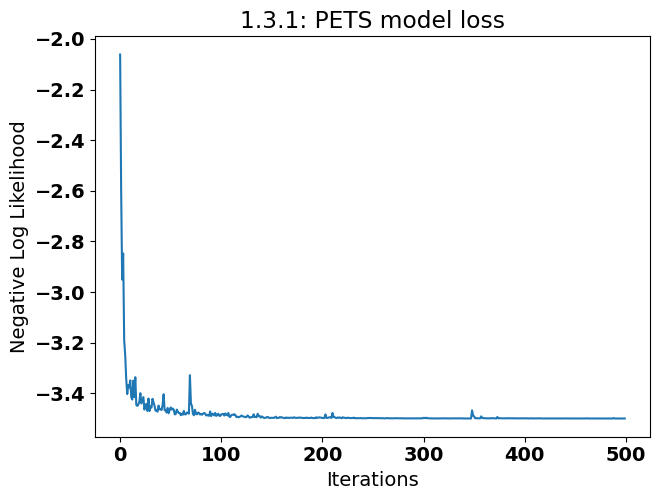

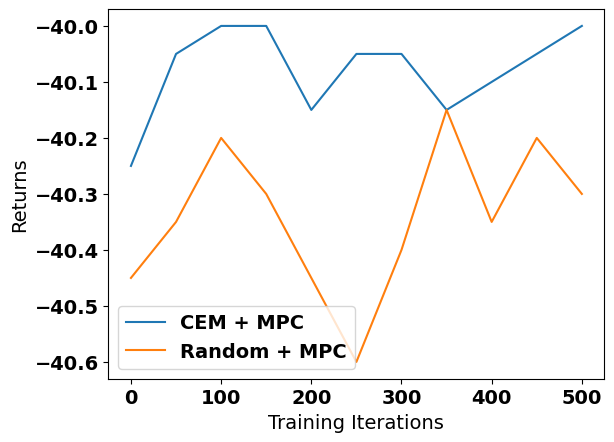

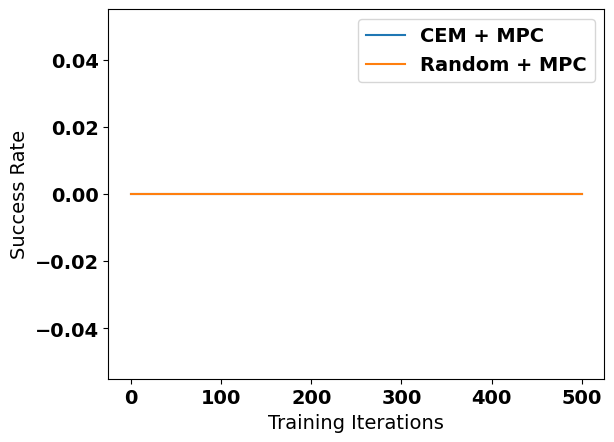

In [207]:
gpu_number = 0
device = torch.device('cuda:%d' % gpu_number if torch.cuda.is_available() else 'cpu')

#test_cem_gt_dynamics(50)    # Q1.1
#train_single_dynamics(50, device=device)   # Q1.2
train_pets(device=device)  # Q1.3